<a href="https://colab.research.google.com/github/zulai98/AMD-project/blob/main/Algorithms_for_Massive_Datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Mount drives to load them
from google.colab import drive
 

In [1]:
!pip install kaggle


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
os.environ["KAGGLE_USERNAME"] = "giulialob"
os.environ["KAGGLE_KEY"] = "d39799005be12f6ee0e278d0afddda99"

In [3]:
!kaggle datasets download -d bwandowando/ukraine-russian-crisis-twitter-dataset-1-2-m-rows


100% 12.3G/12.3G [04:00<00:00, 53.6MB/s]
100% 12.3G/12.3G [04:00<00:00, 54.8MB/s]


In [4]:
!unzip ukraine-russian-crisis-twitter-dataset-1-2-m-rows.zip 

Archive:  ukraine-russian-crisis-twitter-dataset-1-2-m-rows.zip
  inflating: 0819_UkraineCombinedTweetsDeduped.csv.gzip  
  inflating: 0820_UkraineCombinedTweetsDeduped.csv.gzip  
  inflating: 0821_UkraineCombinedTweetsDeduped.csv.gzip  
  inflating: 0822_UkraineCombinedTweetsDeduped.csv.gzip  
  inflating: 0823_UkraineCombinedTweetsDeduped.csv.gzip  
  inflating: 0824_UkraineCombinedTweetsDeduped.csv.gzip  
  inflating: 0825_UkraineCombinedTweetsDeduped.csv.gzip  
  inflating: 0826_UkraineCombinedTweetsDeduped.csv.gzip  
  inflating: 0827_UkraineCombinedTweetsDeduped.csv.gzip  
  inflating: 0828_UkraineCombinedTweetsDeduped.csv.gzip  
  inflating: 0829_UkraineCombinedTweetsDeduped.csv.gzip  
  inflating: 0830_UkraineCombinedTweetsDeduped.csv.gzip  
  inflating: 0831_UkraineCombinedTweetsDeduped.csv.gzip  
  inflating: 0901_UkraineCombinedTweetsDeduped.csv.gzip  
  inflating: 0902_UkraineCombinedTweetsDeduped.csv.gzip  
  inflating: 0903_UkraineCombinedTweetsDeduped.csv.gzip  
  inflat

In [8]:
!mkdir UkrWar
!rm -rf sample_data

In [33]:
!gzip -l *.gz
#          278455064           732598840  62.0% UkraineCombinedTweetsDeduped20220227-131611.csv
#          82892498           209652014  60.5% UkraineCombinedTweetsDeduped_FEB27.csv
#          35812015            97510321  63.3% 0722_UkraineCombinedTweetsDeduped.csv
#          28378314            72450067  60.8% 0921_UkraineCombinedTweetsDeduped.csv.gzip
#          17729064            47865629  63.0% 0808_UkraineCombinedTweetsDeduped.csv
#          14550285            38189130  61.9% 1005_UkraineCombinedTweetsDeduped.csv.gzip
#          12507492            33878722  63.1% 0818_UkraineCombinedTweetsDeduped.csv


         compressed        uncompressed  ratio uncompressed_name
           84434516           219533443  61.5% 0401_UkraineCombinedTweetsDeduped.csv
           83271492           221367381  62.4% 0402_UkraineCombinedTweetsDeduped.csv
          100213353           266178275  62.4% 0403_UkraineCombinedTweetsDeduped.csv
           98707386           256320083  61.5% 0404_UkraineCombinedTweetsDeduped.csv
          106306921           273469217  61.1% 0405_UkraineCombinedTweetsDeduped.csv
           99734645           257606285  61.3% 0406_UkraineCombinedTweetsDeduped.csv
           90274322           230445167  60.8% 0407_UkraineCombinedTweetsDeduped.csv
           94538537           246757806  61.7% 0408_UkraineCombinedTweetsDeduped.csv
           92164537           243386796  62.1% 0409_UkraineCombinedTweetsDeduped.csv
           84251394           225925491  62.7% 0410_UkraineCombinedTweetsDeduped.csv
           85328851           228111355  62.6% 0411_UkraineCombinedTweetsDeduped.csv


In [9]:
sh = """
for file in UkraineWar/UkraineWar/*.gzip; do
    mv "$file" UkrWar/"$(basename "$file" .gzip).gz"
done
for file in *.gzip; do
    mv "$file" UkrWar/"$(basename "$file".gzip).gz"
done
"""
with open('script.sh', 'w') as file:
  file.write(sh)

!bash script.sh

In [10]:
!rm -rf UkraineWar
!rm -rf sample_data

In [106]:
#Find first date 
sh = """
(find $PWD -type f -iname "*FEB27*" )
"""
with open('script.sh', 'w') as file:
  file.write(sh)

!bash script.sh
#*FEB27*

/content/UkrWar/UkraineCombinedTweetsDeduped_FEB27.csv.gz.gz


In [109]:
FILENAME='/content/UkrWar/UkraineCombinedTweetsDeduped_FEB27.csv.gz.gz'

In [15]:
#Install Pyspark
%%capture
!pip install pyspark
!pip install findspark
!pip install spark-nlp==4.2.0


In [16]:
import numpy as np
import pandas as pd
import csv
import os
from pyspark.sql import SparkSession, Row
import random
import sparknlp
import math

from sparknlp.base import *
from sparknlp.annotator import *
from pyspark.ml import Pipeline

In [17]:
# Build spark context
spark = sparknlp.start()
sc = spark.sparkContext

In [110]:
# Loading the data from Market_Basket_Optimisation.csv inside the dataframe
raw_df = spark.read.csv(FILENAME, header=True, escape="\"", quote="\"", multiLine=True)


In [43]:
raw_df.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- userid: string (nullable = true)
 |-- username: string (nullable = true)
 |-- acctdesc: string (nullable = true)
 |-- location: string (nullable = true)
 |-- following: string (nullable = true)
 |-- followers: string (nullable = true)
 |-- totaltweets: string (nullable = true)
 |-- usercreatedts: string (nullable = true)
 |-- tweetid: string (nullable = true)
 |-- tweetcreatedts: string (nullable = true)
 |-- retweetcount: string (nullable = true)
 |-- text: string (nullable = true)
 |-- hashtags: string (nullable = true)
 |-- language: string (nullable = true)
 |-- coordinates: string (nullable = true)
 |-- favorite_count: string (nullable = true)
 |-- extractedts: string (nullable = true)



In [111]:
raw_df.show()

+-------+-------------------+---------------+--------------------+--------------------+---------+---------+-----------+--------------------+-------------------+-------------------+------------+--------------------+--------------------+--------+-----------+--------------+--------------------+
|    _c0|             userid|       username|            acctdesc|            location|following|followers|totaltweets|       usercreatedts|            tweetid|     tweetcreatedts|retweetcount|                text|            hashtags|language|coordinates|favorite_count|         extractedts|
+-------+-------------------+---------------+--------------------+--------------------+---------+---------+-----------+--------------------+-------------------+-------------------+------------+--------------------+--------------------+--------+-----------+--------------+--------------------+
|1141800|1466752038960656385| Curtin2Tiffany|I am just like ev...|       Colorado, USA|      253|       40|         94|20

In [112]:
raw_df.show(n=5, truncate=False)

+-------+-------------------+---------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------+---------+---------+-----------+--------------------------+-------------------+-------------------+------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------+-----------+--------------+--------------------------+
|_c0    |userid             |username       |acctdesc                                                                                   

In [113]:
raw_df.select('language').distinct().show()

+--------+
|language|
+--------+
|      en|
|      ne|
|      vi|
|      ps|
|      ro|
|      sl|
|     und|
|      ur|
|      ka|
|      lv|
|      pl|
|      hy|
|      pt|
|    null|
|      tl|
|      in|
|      ko|
|      uk|
|      cs|
|     ckb|
+--------+
only showing top 20 rows



In [114]:
raw_df.select('language').distinct().count()

63

In [115]:
lang_dist=raw_df.groupby('language').count()
lang_dist.show()

+--------+------+
|language| count|
+--------+------+
|      en|227513|
|      ne|    15|
|      vi|    21|
|      ps|    10|
|      ro|   263|
|      sl|    38|
|     und| 13800|
|      ur|   526|
|      ka|    40|
|      lv|    40|
|      pl|  4505|
|      hy|     1|
|      pt|  2097|
|    null|     2|
|      tl|   138|
|      in|   560|
|      ko|   317|
|      uk|  1004|
|      cs|   275|
|     ckb|    16|
+--------+------+
only showing top 20 rows



In [116]:
langdistribution=lang_dist.toPandas()
langdistribution=langdistribution.set_index("language")
langdistribution

,count
language,
en,227513
ne,15
vi,21
ps,10
ro,263
...,...
am,16
ja,3572
or,21


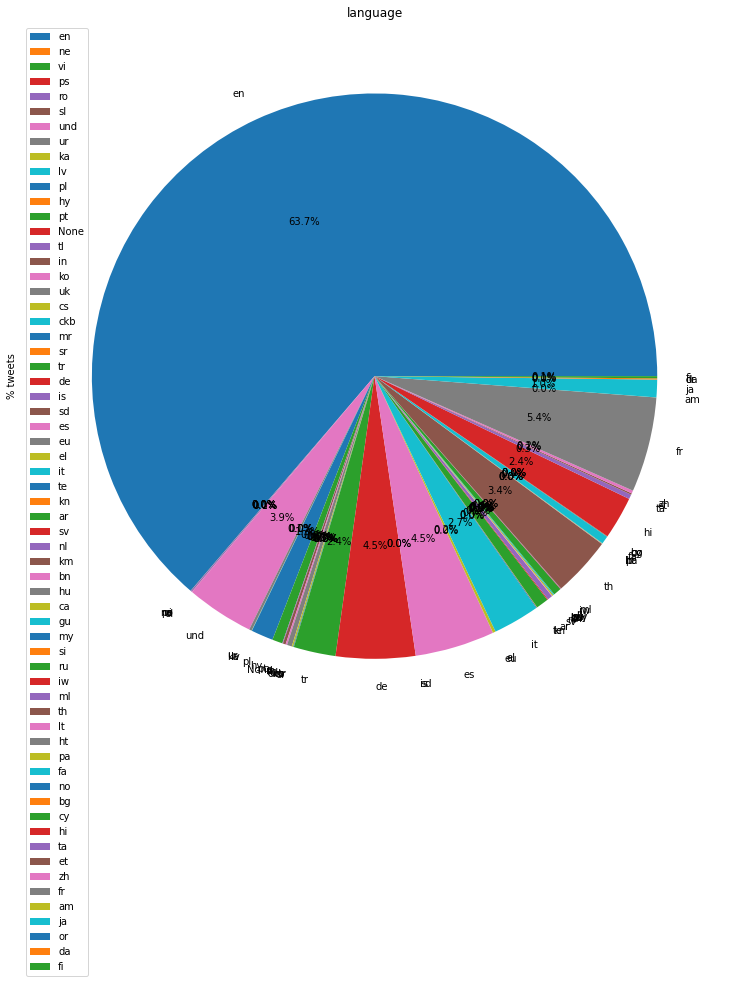

In [117]:
pie = langdistribution.plot.pie(y = "count", figsize = (13,13), autopct = "%1.1f%%")
pie.legend(loc = "upper left");
pie.set(title = "language", ylabel = "% tweets");

In [118]:
# Choose English -- most tweets
english_select=raw_df.where(raw_df.language == "en")

In [119]:
english_select.show(truncate=False)

+-------+-------------------+---------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------+---------+---------+-----------+--------------------------+-------------------+-------------------+------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------+-----------+--------------+--------------------------+
|_c0    |userid             |use

In [120]:
filtered_df = english_select.select("text")

In [121]:
filtered_df.show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|text                                                                                                                                                                                                                                                                                                                                   |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|#UkraineR

Define PreProcessing Pipeline

In [18]:
# In this step we define a sparkNLP pipeline which will preprocess our data
# by tokenizing it and removing unwanted tokens

from sparknlp.base import *
from sparknlp.annotator import *

def create_preprocessing_pipeline():
  documentAssembler = DocumentAssembler().setInputCol("text").setOutputCol("document")
  tokenizer = Tokenizer().setInputCols(["document"]).setOutputCol("token")
    #remove links
  linkRemover = Normalizer().setInputCols(["token"]).setOutputCol("tokensWoutLinks") \
  .setCleanupPatterns(["http\S+|www\S+|https\S+"]).setLowercase(True)#convert to lowercase
      #no whitespace or http (:)
    #[^\s]--keep spaces
    #[^\d]--keep numbers
    #[^\w]--keep letters
#remove punctuation
  punctuationRemover = Normalizer().setInputCols(["tokensWoutLinks"]).setOutputCol("tokensWoutLinksAndPuct") \
    .setCleanupPatterns(["&(amp)|@[A-Za-z0-9]+|[^\w ]|_|"])#regex remove all '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~' 
  #keep spaces
  stopWordsCleaner =  StopWordsCleaner.pretrained('stopwords_en', 'en').setInputCols("tokensWoutLinksAndPuct").setOutputCol("cleanedTokens")\
      .setCaseSensitive(False)#
  stemmer = Stemmer().setInputCols(["cleanedTokens"]).setOutputCol("cleanedStemmedTokens")
  
  return Pipeline().setStages([
    documentAssembler,
    tokenizer,
    linkRemover,
    punctuationRemover,
    stopWordsCleaner,
    stemmer
])
def apply_preprocessing_pipeline(pipeline, dataframe):
    return pipeline.fit(dataframe).transform(dataframe).selectExpr("cleanedStemmedTokens.result")

In [210]:
preprocessed_df=apply_preprocessing_pipeline(create_preprocessing_pipeline(),filtered_df)

stopwords_en download started this may take some time.
Approximate size to download 2.9 KB
[OK!]


In [123]:
preprocessed_df.show(truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|result                                                                                                                                                                                                                                    |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[ukrainerussiawar, captur, russian, soldier, battalion, told, train, ukrain, russianarmi, soldier, ukrain, ukrainerussiawar]                                                                                                              |
|[root, ukrain, fight, russia, video, sad, soldier, 

In [125]:
#Remove duplicates
input_rdd = preprocessed_df.rdd.map(lambda x: ( list(set(x[0]))))#reorder
input_rdd.take(2)

[['train',
  'captur',
  'ukrain',
  'russianarmi',
  'battalion',
  'soldier',
  'ukrainerussiawar',
  'told',
  'russian'],
 ['clueless',
  'ukrain',
  'corrupt',
  'ukraineunderattack',
  'dictat',
  'vladimir',
  'fight',
  'dont',
  'soldier',
  'putin',
  'russia',
  'ukrainerussiawar',
  'ukrania',
  'forc',
  'lost',
  'sad',
  'video',
  'root']]

In [ ]:
#If needed --save to file to inspect
#!rm -rf itemsets.txt
#input_rdd.saveAsTextFile('itemsets.txt')

In [131]:
n_of_baskets = input_rdd.count()#countlenght
MIN_SUPPORT_PERC = 0.2
MIN_SUPPORT = math.ceil(n_of_baskets * MIN_SUPPORT_PERC)


In [132]:
MIN_SUPPORT

45503

In [133]:

#FREQUENT SINGLETONS

singleton_itemsets_rdd = input_rdd.flatMap(lambda x:x).map(lambda x: (x,1))

# Compute frequencies using a reduce operation
singleton_itemsets_w_frequencies_rdd = singleton_itemsets_rdd.reduceByKey(lambda x,y: x + y)
#add 1 if/per count

# Filter singletons with a frequency higher than THRESHOLD
frequent_singleton_itemsets_rdd = singleton_itemsets_w_frequencies_rdd.map(lambda x: (x[0], x[1])).filter(lambda x: x[1] > MIN_SUPPORT)

# These are examples of frequent singleton itemsets with the relative frequency
frequent_singleton_itemsets_rdd.take(10)#support

#supportRDD.take(10)

[('ukrain', 163217), ('russian', 63249), ('putin', 46503), ('russia', 83932)]

In [134]:
frequents_RDD= frequent_singleton_itemsets_rdd.map(lambda x:x[0])  
frequents_RDD.take(10)##this must not be empty ..first 10 elemnts

['ukrain', 'russian', 'putin', 'russia']

Get All Possible Candidates Function

In [19]:
import itertools
def get_all_possible_candidates(frequents,n):#all possible combo.
  frequents=frequents.collect()#all of them
  if (n==2):
    singles = set()
    for item in frequents:#for item
      singles.add(item)#add if unique
    
  if (n>2):
    singles=set() 
    for itemsets in frequents: 
      for item in itemsets: #Get each individual item>
        singles.add(item) 
  print(singles)      
  candidates=[set(itemsets) for itemsets in list(itertools.combinations(singles, n))] 
  #itertools.combinations(singles, n) combo of singles to form n-uples
  print(candidates)
  #Create a list of the combinations (no rep., single)
  return candidates

<br>**filter_and_map_transaction()**
<br> <br>The function is expected to compare each item with the candidate set. If the item is present in the transaction, the corresponding item in the candidate set must be mapped with value 1 and if they are absent, then the value must be 0.

In [20]:
#Is combo of items a subset of the ini transaction set
#Put 1 if combo of item is in ini transaction set
def count_candidates(x, candidates):
    c_list = []
    for itemsets in candidates:
        print(itemsets)                     
        if set(list(itemsets)).issubset(set(x)):#if candidate 
            c_list.append([tuple(itemsets), 1])
            print(c_list)
        else:
            c_list.append([tuple(itemsets), 0])
    return c_list

In [21]:
def get_frequent_itemsets(candidates, itemsets, MIN_SUPPORT):
    frequent_item_set = itemsets.flatMap(lambda x: count_candidates(x, candidates)).reduceByKey(lambda a, b: a+b).map(lambda x: x).filter(lambda x: x[1]>=MIN_SUPPORT)
    return frequent_item_set

In [138]:
candidate_sets = get_all_possible_candidates(frequents_RDD, 2)#items --list

{'putin', 'russia', 'ukrain', 'russian'}
[{'putin', 'russia'}, {'putin', 'ukrain'}, {'putin', 'russian'}, {'russia', 'ukrain'}, {'russia', 'russian'}, {'ukrain', 'russian'}]


In [139]:
len(candidate_sets)##36 possible comb (9!/(2!*7!))

6

In [140]:
candidate_sets#combo--tuple,0 or 1

[{'putin', 'russia'},
 {'putin', 'ukrain'},
 {'putin', 'russian'},
 {'russia', 'ukrain'},
 {'russia', 'russian'},
 {'russian', 'ukrain'}]

In [141]:
frequent_itemsets = get_frequent_itemsets(candidate_sets, input_rdd, MIN_SUPPORT)

In [142]:
frequents_pair_RDD = frequent_itemsets.map(lambda x:x[0])

In [143]:
frequent_itemsets.take(5)

[(('russia', 'ukrain'), 63693), (('ukrain', 'russian'), 49165)]

In [144]:
frequents_pair_RDD.take(5)

[('russia', 'ukrain'), ('ukrain', 'russian')]

In [145]:
candidate_sets = get_all_possible_candidates(frequents_pair_RDD, 3)#items --list

{'russia', 'russian', 'ukrain'}
[{'russia', 'russian', 'ukrain'}]


In [146]:
frequent_itemsets = get_frequent_itemsets(candidate_sets, input_rdd, MIN_SUPPORT)

In [147]:
frequents_trip_RDD = frequent_itemsets.map(lambda x:x[0])


In [148]:
frequents_trip_RDD.take(10)

[]

In [ ]:
#Runtime vs support graph -- size

Get specific date shell script

In [30]:
sh = """
specialformat=true
if  [ $1 = "02" ]
then
  var="FEB"
  echo $var
elif  [ $1 = "03" ]
then
  var="MAR"
  echo $var
else
  specialformat=false
fi
if $specialformat
then
  (find $PWD -type f -iname "*$var$2*" )|tee out
else
  (find $PWD -type f -iname "*$1$2*" )|tee out
fi

"""
with open('find_file_data.sh', 'w') as file:
  file.write(sh)


In [23]:
#Generate a priori algorithm
  #need a while loop
def not_empty(freq_sets):
    return (freq_sets.count() > 0) and (freq_sets is not None)

In [24]:
def apriori(input_rdd,MIN_SUPPORT):
      
   tweet_freqRDD=(input_rdd.flatMap(lambda x:x).map(lambda i: (i, 1)).reduceByKey(lambda a,b: a+b))
   frequent_items_and_count_RDD= tweet_freqRDD.map(lambda x: (x[0], x[1])).filter(lambda x: x[1]>=MIN_SUPPORT)    
   frequent_items_RDD= frequent_items_and_count_RDD.map(lambda x:x[0])  
   n=2
   input_rdd.cache()
   frequent_items_and_count_RDD = sc.parallelize([]) 

   while not_empty(frequent_items_RDD):
     
     candidate_sets = get_all_possible_candidates(frequent_items_RDD, n)
     frequent_itemsets = get_frequent_itemsets(candidate_sets, input_rdd, MIN_SUPPORT)
     frequent_items_and_count_RDD  = frequent_items_and_count_RDD.union(frequent_itemsets)#support
     frequent_items_RDD = frequent_itemsets.map(lambda x:x[0])
     
   
     n += 1
   input_rdd.unpersist()
   return frequent_items_and_count_RDD

In [25]:
def apply_preprocessing_pipeline(pipeline, dataframe):
    return pipeline.fit(dataframe).transform(dataframe).selectExpr("cleanedStemmedTokens.result")

In [26]:
#Try to get a story out of it
# Set limit = -1 to avoid limit
# for FEB28 we specify only part1

# The idea of this function is to apply the a_priori_algorithm just by specifing the date which we want to process 
# (and a few other input params)
def generate_results(FILENAME, preprocessing_pipeline, TRESHOLD_PERCENTAGE):

  # Reading and filtering the dataset
  raw_df = spark.read.csv(FILENAME, header=True, escape="\"", quote="\"", multiLine=True)
  filtered_df = raw_df.where(raw_df.language == "en").select("text")

  # Preprocessing the dataset using a predefined pipeline (This avoid having to re-download the stopwords set each time)
  preprocessed_df = apply_preprocessing_pipeline(preprocessing_pipeline,filtered_df)
  # Preparing the RDD for the a_priori_algorithm
  input_rdd = preprocessed_df.rdd.map(lambda x: (list(set(x[0]))))

  # Defining the threshold
  n_of_baskets = input_rdd.count()#countlenght -> 227,513 (rows)
  print('No of tweets are ', n_of_baskets)
  TRESHOLD = math.ceil(n_of_baskets * TRESHOLD_PERCENTAGE)
  print('Min support is ' , TRESHOLD)
  # Returning the actual result
  import time ## min_support=0.0004
  start_time = time.time()
  result=apriori(input_rdd, TRESHOLD)
  end_time = time.time()
  print('Runtime is' , end_time - start_time)

  return result

In [32]:
# Defining the pipeline once (donwload stopwords only once)
preprocessing_pipeline = create_preprocessing_pipeline()

stopwords_en download started this may take some time.
Approximate size to download 2.9 KB
[OK!]


In [35]:
!rm out
!bash find_file_data.sh 02 27
with open('out', 'r') as file:
    PATHNAME = file.readline().strip()
    if(PATHNAME == ''):
      print("Data not found -- exit")
    else:
      result_02_27_C005=generate_results(PATHNAME, preprocessing_pipeline,0.05)

FEB
/content/UkrWar/UkraineCombinedTweetsDeduped_FEB27.csv.gz.gz
No of tweets are  227513
Min support is  11376
{'anonym', 'ukrainewar', 'ukraineunderattack', 'world', 'russiaukrainewar', 'kyiv', 'putin', 'ukrainerussiawar', 'war', 'support', 'militari', 'ukrainian', 'ukrain', 'standwithukrain', 'countri', 'russia', 'russian', 'peopl'}
[{'ukrainewar', 'anonym'}, {'ukraineunderattack', 'anonym'}, {'anonym', 'world'}, {'anonym', 'russiaukrainewar'}, {'kyiv', 'anonym'}, {'putin', 'anonym'}, {'ukrainerussiawar', 'anonym'}, {'war', 'anonym'}, {'support', 'anonym'}, {'militari', 'anonym'}, {'ukrainian', 'anonym'}, {'ukrain', 'anonym'}, {'anonym', 'standwithukrain'}, {'anonym', 'countri'}, {'russia', 'anonym'}, {'russian', 'anonym'}, {'peopl', 'anonym'}, {'ukrainewar', 'ukraineunderattack'}, {'ukrainewar', 'world'}, {'ukrainewar', 'russiaukrainewar'}, {'kyiv', 'ukrainewar'}, {'putin', 'ukrainewar'}, {'ukrainerussiawar', 'ukrainewar'}, {'ukrainewar', 'war'}, {'support', 'ukrainewar'}, {'ukrain

In [36]:
#Focus on one day (largest) -- but vary LIMIT--record time (take 5 measures). Find best compromise for future ones
#find file
!rm out
!bash find_file_data.sh 02 27
with open('out', 'r') as file:
    PATHNAME = file.readline().strip()
    if(PATHNAME == ''):
      print("Data not found -- exit")
    else:
      result_02_27_C01=generate_results(PATHNAME, preprocessing_pipeline,0.1)

FEB
/content/UkrWar/UkraineCombinedTweetsDeduped_FEB27.csv.gz.gz
No of tweets are  227513
Min support is  22752
{'kyiv', 'putin', 'ukrainerussiawar', 'war', 'ukrainian', 'ukrain', 'russia', 'russian', 'peopl'}
[{'kyiv', 'putin'}, {'kyiv', 'ukrainerussiawar'}, {'kyiv', 'war'}, {'kyiv', 'ukrainian'}, {'kyiv', 'ukrain'}, {'kyiv', 'russia'}, {'kyiv', 'russian'}, {'kyiv', 'peopl'}, {'putin', 'ukrainerussiawar'}, {'putin', 'war'}, {'ukrainian', 'putin'}, {'putin', 'ukrain'}, {'putin', 'russia'}, {'putin', 'russian'}, {'putin', 'peopl'}, {'ukrainerussiawar', 'war'}, {'ukrainian', 'ukrainerussiawar'}, {'ukrainerussiawar', 'ukrain'}, {'russia', 'ukrainerussiawar'}, {'ukrainerussiawar', 'russian'}, {'ukrainerussiawar', 'peopl'}, {'ukrainian', 'war'}, {'war', 'ukrain'}, {'russia', 'war'}, {'war', 'russian'}, {'war', 'peopl'}, {'ukrainian', 'ukrain'}, {'ukrainian', 'russia'}, {'ukrainian', 'russian'}, {'ukrainian', 'peopl'}, {'russia', 'ukrain'}, {'russian', 'ukrain'}, {'ukrain', 'peopl'}, {'russi

In [37]:
#Focus on one day (largest)-- but vary LIMIT--record time (take 5 measures). Find best compromise for future ones
#find file
!rm out
!bash find_file_data.sh 02 27
with open('out', 'r') as file:
    PATHNAME = file.readline().strip()
    if(PATHNAME == ''):
      print("Data not found -- exit")
    else:
      result_02_27_C015=generate_results(PATHNAME, preprocessing_pipeline,0.15)

FEB
/content/UkrWar/UkraineCombinedTweetsDeduped_FEB27.csv.gz.gz
No of tweets are  227513
Min support is  34127
{'putin', 'ukrainian', 'ukrain', 'russia', 'russian'}
[{'ukrainian', 'putin'}, {'putin', 'ukrain'}, {'putin', 'russia'}, {'putin', 'russian'}, {'ukrainian', 'ukrain'}, {'ukrainian', 'russia'}, {'ukrainian', 'russian'}, {'russia', 'ukrain'}, {'russian', 'ukrain'}, {'russia', 'russian'}]
{'russia', 'russian', 'ukrain'}
[{'russia', 'russian', 'ukrain'}]
Runtime is 1318.6258103847504


In [38]:
#Focus on one day (largest)-- but vary LIMIT--record time (take 5 measures). Find best compromise for future ones
#find file
!rm out
!bash find_file_data.sh 02 27
with open('out', 'r') as file:
    PATHNAME = file.readline().strip()
    if(PATHNAME == ''):
      print("Data not found -- exit")
    else:
      result_02_27_C02=generate_results(PATHNAME, preprocessing_pipeline,0.2)

FEB
/content/UkrWar/UkraineCombinedTweetsDeduped_FEB27.csv.gz.gz
No of tweets are  227513
Min support is  45503
{'putin', 'russia', 'russian', 'ukrain'}
[{'putin', 'russia'}, {'putin', 'russian'}, {'putin', 'ukrain'}, {'russia', 'russian'}, {'russia', 'ukrain'}, {'russian', 'ukrain'}]
{'russia', 'russian', 'ukrain'}
[{'russia', 'russian', 'ukrain'}]
Runtime is 1277.746163368225


In [39]:
#Focus on one day (largest)-- but vary LIMIT--record time (take 5 measures). Find best compromise for future ones
#find file
!rm out
!bash find_file_data.sh 02 27
with open('out', 'r') as file:
    PATHNAME = file.readline().strip()
    if(PATHNAME == ''):
      print("Data not found -- exit")
    else:
      result_02_27_C03=generate_results(PATHNAME, preprocessing_pipeline,0.3)


FEB
/content/UkrWar/UkraineCombinedTweetsDeduped_FEB27.csv.gz.gz
No of tweets are  227513
Min support is  68254
{'russia', 'ukrain'}
[{'russia', 'ukrain'}]
Runtime is 1164.8368389606476


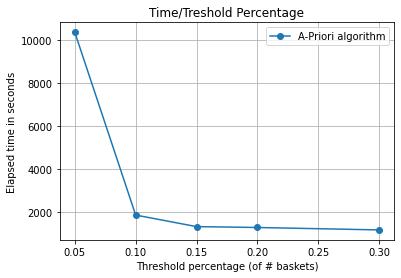

In [65]:
#for feb 
#68254 Runtime is 1164.8368389606476 (.3)
#45503 Runtime is 1277.746163368225 (.2)
#34127 Runtime is 1318.6258103847504 (.15)
#22752 Runtime is 1856.7753727436066 (.1)
#11376 Runtime is 10375.439755678177 (.05)

import matplotlib.pyplot as plt
#treshold=[68254,45503,34127,22752,11376]
treshold_perc=[.3,.2,.15,.1,.05]
elapsed_time=[1164.8,1277.7,1318.6,1856.7,10375.4]

#apriori plot for threshold size between 0.0003 and 0.0008 on 25% size sample

time_treshold_perc_ratio = pd.DataFrame()
time_treshold_perc_ratio['Elapsed_time'] = elapsed_time
time_treshold_perc_ratio['Threshold'] = treshold_perc
plt.plot(time_treshold_perc_ratio['Threshold'], time_treshold_perc_ratio['Elapsed_time'],
         label = 'A-Priori algorithm', marker = 'o')
plt.xlabel('Threshold percentage (of # baskets)')
plt.ylabel('Elapsed time in seconds')
plt.savefig('time_threshold_perc_ratio.jpg')
plt.legend()
plt.grid()
plt.title('Time/Treshold Percentage')
plt.show()
##explain the jump

In [41]:
#Collect times and C -- plot graph

In [42]:
#For 02 27 -- get the best C

In [43]:
BEST_MIN_SUPPORT=0.1

In [ ]:
#          278455064           732598840  62.0% UkraineCombinedTweetsDeduped20220227-131611.csv
#          82892498           209652014  60.5% UkraineCombinedTweetsDeduped_FEB27.csv
#          35812015            97510321  63.3% 0722_UkraineCombinedTweetsDeduped.csv
#          28378314            72450067  60.8% 0921_UkraineCombinedTweetsDeduped.csv.gzip
#          14550285            38189130  61.9% 1005_UkraineCombinedTweetsDeduped.csv.gzip
#          12507492            33878722  63.1% 0818_UkraineCombinedTweetsDeduped.csv


In [48]:
!rm out
!bash find_file_data.sh 03 06
with open('out', 'r') as file:
    PATHNAME = file.readline().strip()
    if(PATHNAME == ''):
      print("Data not found -- exit")
    else:
      generate_results(PATHNAME, preprocessing_pipeline,BEST_MIN_SUPPORT)

MAR
/content/UkrWar/UkraineCombinedTweetsDeduped_MAR06.csv.gz
No of tweets are  396249
Min support is  39625
{'ukrainian', 'innoc', 'stop', 'war', 'humanitarian', 'standwithukrain', 'provid', 'weapon', 'russia', 'ukrainerussianwar', 'russian', 'defend', 'civilian', 'putin', 'peopl', 'ukrain'}
[{'ukrainian', 'innoc'}, {'ukrainian', 'stop'}, {'ukrainian', 'war'}, {'ukrainian', 'humanitarian'}, {'ukrainian', 'standwithukrain'}, {'ukrainian', 'provid'}, {'ukrainian', 'weapon'}, {'ukrainian', 'russia'}, {'ukrainian', 'ukrainerussianwar'}, {'ukrainian', 'russian'}, {'ukrainian', 'defend'}, {'ukrainian', 'civilian'}, {'ukrainian', 'putin'}, {'ukrainian', 'peopl'}, {'ukrainian', 'ukrain'}, {'innoc', 'stop'}, {'innoc', 'war'}, {'innoc', 'humanitarian'}, {'innoc', 'standwithukrain'}, {'innoc', 'provid'}, {'innoc', 'weapon'}, {'russia', 'innoc'}, {'innoc', 'ukrainerussianwar'}, {'innoc', 'russian'}, {'innoc', 'defend'}, {'innoc', 'civilian'}, {'putin', 'innoc'}, {'innoc', 'peopl'}, {'innoc', 'ukr

In [49]:
!rm out
#month -day
!bash find_file_data.sh 04 07
with open('out', 'r') as file:
    PATHNAME = file.readline().strip()
    if(PATHNAME == ''):
      print("Data not found -- exit")
    else:
      generate_results(PATHNAME, preprocessing_pipeline,BEST_MIN_SUPPORT)

/content/UkrWar/0407_UkraineCombinedTweetsDeduped.csv.gz
No of tweets are  259123
Min support is  25913
{'ukrainian', 'war', 'standwithukrain', 'bucha', 'russia', 'russian', 'peopl', 'ukrain'}
[{'ukrainian', 'war'}, {'ukrainian', 'standwithukrain'}, {'ukrainian', 'bucha'}, {'ukrainian', 'russia'}, {'ukrainian', 'russian'}, {'ukrainian', 'peopl'}, {'ukrainian', 'ukrain'}, {'standwithukrain', 'war'}, {'bucha', 'war'}, {'russia', 'war'}, {'russian', 'war'}, {'peopl', 'war'}, {'ukrain', 'war'}, {'standwithukrain', 'bucha'}, {'russia', 'standwithukrain'}, {'standwithukrain', 'russian'}, {'peopl', 'standwithukrain'}, {'standwithukrain', 'ukrain'}, {'russia', 'bucha'}, {'bucha', 'russian'}, {'peopl', 'bucha'}, {'ukrain', 'bucha'}, {'russia', 'russian'}, {'russia', 'peopl'}, {'russia', 'ukrain'}, {'peopl', 'russian'}, {'ukrain', 'russian'}, {'peopl', 'ukrain'}]
{'ukrainian', 'russia', 'ukrain', 'russian'}
[{'ukrainian', 'russia', 'ukrain'}, {'ukrainian', 'russia', 'russian'}, {'ukrainian', 'uk

In [42]:
!rm out
!bash find_file_data.sh 05 16
with open('out', 'r') as file:
    PATHNAME = file.readline().strip()
    if(PATHNAME == ''):
      print("Data not found -- exit")
    else:
      generate_results(PATHNAME, preprocessing_pipeline,BEST_MIN_SUPPORT)

/content/UkrWar/0516_UkraineCombinedTweetsDeduped.csv.gz
No of tweets are  258309
Min support is  25831
{'ukrainian', 'tigrai', 'russia', 'russian', 'ukrain'}
[{'ukrainian', 'tigrai'}, {'ukrainian', 'russia'}, {'ukrainian', 'russian'}, {'ukrainian', 'ukrain'}, {'russia', 'tigrai'}, {'tigrai', 'russian'}, {'tigrai', 'ukrain'}, {'russia', 'russian'}, {'russia', 'ukrain'}, {'ukrain', 'russian'}]
{'ukrain', 'russian'}
[]
Runtime is 646.5206425189972


In [43]:
!rm out
!bash find_file_data.sh 06 10
with open('out', 'r') as file:
    PATHNAME = file.readline().strip()
    if(PATHNAME == ''):
      print("Data not found -- exit")
    else:
      generate_results(PATHNAME, preprocessing_pipeline,BEST_MIN_SUPPORT)

/content/UkrWar/0610_UkraineCombinedTweetsDeduped.csv.gz
No of tweets are  182985
Min support is  18299
{'ukrainian', 'tigrai', 'war', 'russia', 'russian', 'ukrain'}
[{'ukrainian', 'tigrai'}, {'ukrainian', 'war'}, {'ukrainian', 'russia'}, {'ukrainian', 'russian'}, {'ukrainian', 'ukrain'}, {'tigrai', 'war'}, {'russia', 'tigrai'}, {'tigrai', 'russian'}, {'tigrai', 'ukrain'}, {'russia', 'war'}, {'russian', 'war'}, {'ukrain', 'war'}, {'russia', 'russian'}, {'russia', 'ukrain'}, {'ukrain', 'russian'}]
{'ukrainian', 'russia', 'ukrain', 'russian'}
[{'ukrainian', 'russia', 'ukrain'}, {'ukrainian', 'russia', 'russian'}, {'ukrainian', 'ukrain', 'russian'}, {'russia', 'ukrain', 'russian'}]
Runtime is 496.0256106853485


In [44]:
!rm out
!bash find_file_data.sh 07 22
with open('out', 'r') as file:
    PATHNAME = file.readline().strip()
    if(PATHNAME == ''):
      print("Data not found -- exit")
    else:
      generate_results(PATHNAME, preprocessing_pipeline,BEST_MIN_SUPPORT)

/content/UkrWar/0722_UkraineCombinedTweetsDeduped.csv.gz
No of tweets are  88929
Min support is  8893
{'ukrainian', 'war', 'standwithukrain', 'russia', 'russian', 'putin', 'ukrain', 'world'}
[{'ukrainian', 'war'}, {'ukrainian', 'standwithukrain'}, {'ukrainian', 'russia'}, {'ukrainian', 'russian'}, {'ukrainian', 'putin'}, {'ukrainian', 'ukrain'}, {'ukrainian', 'world'}, {'standwithukrain', 'war'}, {'russia', 'war'}, {'russian', 'war'}, {'putin', 'war'}, {'ukrain', 'war'}, {'world', 'war'}, {'russia', 'standwithukrain'}, {'standwithukrain', 'russian'}, {'putin', 'standwithukrain'}, {'standwithukrain', 'ukrain'}, {'standwithukrain', 'world'}, {'russia', 'russian'}, {'russia', 'putin'}, {'russia', 'ukrain'}, {'russia', 'world'}, {'putin', 'russian'}, {'ukrain', 'russian'}, {'world', 'russian'}, {'putin', 'ukrain'}, {'putin', 'world'}, {'ukrain', 'world'}]
{'russia', 'ukrain', 'russian'}
[{'russia', 'ukrain', 'russian'}]
Runtime is 253.8920032978058


In [45]:
!rm out
!bash find_file_data.sh 08 18
with open('out', 'r') as file:
    PATHNAME = file.readline().strip()
    if(PATHNAME == ''):
      print("Data not found -- exit")
    else:
      generate_results(PATHNAME, preprocessing_pipeline,BEST_MIN_SUPPORT)

/content/UkrWar/0818_UkraineCombinedTweetsDeduped.csv.gz
No of tweets are  22991
Min support is  2300
{'ukrainian', 'war', 'russia', 'russian', 'ukrain'}
[{'ukrainian', 'war'}, {'ukrainian', 'russia'}, {'ukrainian', 'russian'}, {'ukrainian', 'ukrain'}, {'russia', 'war'}, {'russian', 'war'}, {'ukrain', 'war'}, {'russia', 'russian'}, {'russia', 'ukrain'}, {'ukrain', 'russian'}]
{'russia', 'ukrain'}
[]
Runtime is 54.70946216583252


In [52]:
!rm out
!bash find_file_data.sh 08 18
with open('out', 'r') as file:
    PATHNAME = file.readline().strip()
    if(PATHNAME == ''):
      print("Data not found -- exit")
    else:
      generate_results(PATHNAME, preprocessing_pipeline,0.05)

/content/UkrWar/0818_UkraineCombinedTweetsDeduped.csv.gz
No of tweets are  22991
Min support is  1150
{'ukrainian', 'russiaisateroristst', 'china', 'war', 'standwithukrain', 'russiaisaterroristst', 'russia', 'militari', 'biden', 'ukrainerussiawar', 'russian', 'putin', 'peopl', 'ukrain'}
[{'ukrainian', 'russiaisateroristst'}, {'ukrainian', 'china'}, {'ukrainian', 'war'}, {'ukrainian', 'standwithukrain'}, {'ukrainian', 'russiaisaterroristst'}, {'ukrainian', 'russia'}, {'ukrainian', 'militari'}, {'ukrainian', 'biden'}, {'ukrainian', 'ukrainerussiawar'}, {'ukrainian', 'russian'}, {'ukrainian', 'putin'}, {'ukrainian', 'peopl'}, {'ukrainian', 'ukrain'}, {'russiaisateroristst', 'china'}, {'russiaisateroristst', 'war'}, {'russiaisateroristst', 'standwithukrain'}, {'russiaisateroristst', 'russiaisaterroristst'}, {'russia', 'russiaisateroristst'}, {'militari', 'russiaisateroristst'}, {'russiaisateroristst', 'biden'}, {'russiaisateroristst', 'ukrainerussiawar'}, {'russiaisateroristst', 'russian'}

In [46]:
!rm out
!bash find_file_data.sh 09 21
with open('out', 'r') as file:
    PATHNAME = file.readline().strip()
    if(PATHNAME == ''):
      print("Data not found -- exit")
    else:
      generate_results(PATHNAME, preprocessing_pipeline,BEST_MIN_SUPPORT)

/content/UkrWar/0921_UkraineCombinedTweetsDeduped.csv.gzip.gzip.gz
No of tweets are  47859
Min support is  4786
{'war', 'russia', 'ukrainerussiawar', 'russian', 'putin', 'ukrain'}
[{'russia', 'war'}, {'ukrainerussiawar', 'war'}, {'russian', 'war'}, {'putin', 'war'}, {'ukrain', 'war'}, {'russia', 'ukrainerussiawar'}, {'russia', 'russian'}, {'russia', 'putin'}, {'russia', 'ukrain'}, {'ukrainerussiawar', 'russian'}, {'putin', 'ukrainerussiawar'}, {'ukrainerussiawar', 'ukrain'}, {'putin', 'russian'}, {'ukrain', 'russian'}, {'putin', 'ukrain'}]
{'putin', 'russia', 'ukrain'}
[{'putin', 'russia', 'ukrain'}]
Runtime is 119.03190064430237


In [51]:
##much smaller 
!rm out
!bash find_file_data.sh 09 21
with open('out', 'r') as file:
    PATHNAME = file.readline().strip()
    if(PATHNAME == ''):
      print("Data not found -- exit")
    else:
      generate_results(PATHNAME, preprocessing_pipeline,0.05)

/content/UkrWar/0921_UkraineCombinedTweetsDeduped.csv.gzip.gzip.gz
No of tweets are  47859
Min support is  2393
{'ukrainian', 'war', 'russia', 'ukrainerussiawar', 'biden', 'mobil', 'russian', 'putin', 'peopl', 'ukrain', 'world'}
[{'ukrainian', 'war'}, {'ukrainian', 'russia'}, {'ukrainian', 'ukrainerussiawar'}, {'ukrainian', 'biden'}, {'ukrainian', 'mobil'}, {'ukrainian', 'russian'}, {'ukrainian', 'putin'}, {'ukrainian', 'peopl'}, {'ukrainian', 'ukrain'}, {'ukrainian', 'world'}, {'russia', 'war'}, {'ukrainerussiawar', 'war'}, {'biden', 'war'}, {'mobil', 'war'}, {'russian', 'war'}, {'putin', 'war'}, {'peopl', 'war'}, {'ukrain', 'war'}, {'world', 'war'}, {'russia', 'ukrainerussiawar'}, {'russia', 'biden'}, {'russia', 'mobil'}, {'russia', 'russian'}, {'russia', 'putin'}, {'russia', 'peopl'}, {'russia', 'ukrain'}, {'russia', 'world'}, {'ukrainerussiawar', 'biden'}, {'ukrainerussiawar', 'mobil'}, {'ukrainerussiawar', 'russian'}, {'putin', 'ukrainerussiawar'}, {'ukrainerussiawar', 'peopl'}, {

In [47]:
!rm out
!bash find_file_data.sh 10 05
with open('out', 'r') as file:
    PATHNAME = file.readline().strip()
    if(PATHNAME == ''):
      print("Data not found -- exit")
    else:
      generate_results(PATHNAME, preprocessing_pipeline,BEST_MIN_SUPPORT)

/content/UkrWar/1005_UkraineCombinedTweetsDeduped.csv.gzip.gzip.gz
No of tweets are  25546
Min support is  2555
{'ukrainian', 'war', 'russia', 'russian', 'putin', 'ukrain'}
[{'ukrainian', 'war'}, {'ukrainian', 'russia'}, {'ukrainian', 'russian'}, {'ukrainian', 'putin'}, {'ukrainian', 'ukrain'}, {'russia', 'war'}, {'russian', 'war'}, {'putin', 'war'}, {'ukrain', 'war'}, {'russia', 'russian'}, {'russia', 'putin'}, {'russia', 'ukrain'}, {'putin', 'russian'}, {'ukrain', 'russian'}, {'putin', 'ukrain'}]
{'russia', 'ukrain', 'russian'}
[{'russia', 'ukrain', 'russian'}]
Runtime is 64.93034839630127


In [50]:
!rm out
!bash find_file_data.sh 10 05
with open('out', 'r') as file:
    PATHNAME = file.readline().strip()
    if(PATHNAME == ''):
      print("Data not found -- exit")
    else:
      generate_results(PATHNAME, preprocessing_pipeline,0.05)

/content/UkrWar/1005_UkraineCombinedTweetsDeduped.csv.gzip.gzip.gz
No of tweets are  25546
Min support is  1278
{'ukrainian', 'region', 'war', 'standwithukrain', 'ukrainewar', 'russia', 'ukrainerussiawar', 'nato', 'russian', 'forc', 'putin', 'kherson', 'ukrain', 'world'}
[{'ukrainian', 'region'}, {'ukrainian', 'war'}, {'ukrainian', 'standwithukrain'}, {'ukrainian', 'ukrainewar'}, {'ukrainian', 'russia'}, {'ukrainian', 'ukrainerussiawar'}, {'ukrainian', 'nato'}, {'ukrainian', 'russian'}, {'ukrainian', 'forc'}, {'ukrainian', 'putin'}, {'ukrainian', 'kherson'}, {'ukrainian', 'ukrain'}, {'ukrainian', 'world'}, {'region', 'war'}, {'region', 'standwithukrain'}, {'region', 'ukrainewar'}, {'russia', 'region'}, {'ukrainerussiawar', 'region'}, {'nato', 'region'}, {'region', 'russian'}, {'region', 'forc'}, {'putin', 'region'}, {'kherson', 'region'}, {'region', 'ukrain'}, {'region', 'world'}, {'standwithukrain', 'war'}, {'ukrainewar', 'war'}, {'russia', 'war'}, {'ukrainerussiawar', 'war'}, {'nato'

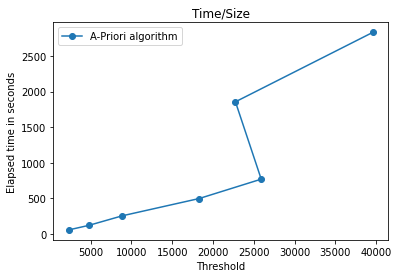

In [57]:
#for minsupport=10% no.baskets --note (one basket) tweets can have more words
#month minsupp time
#feb 22,752 - 1856.8 ---find a lot of words
#mar 39,625 - 2835.2 -----find a lot of words

#apr 25,913 - 768.7 --- prob. less words better
#may 25,813 - 646.52 ##sim to apr in size
#jun 18,299 - 496.02
#jul  8,893 -253.820 
#aug  2,300 -54.7 
#sep  4,786 - 119.0
#oct  2,555 - 64.93 ##sim to aug in size
import matplotlib.pyplot as plt
treshold=[39625, 22752, 25913, 18299, 8893, 4786, 2300]
elapsed_time=[2835.2,1856.8,768.7,496.02,253.82,119.0,54.7]

#apriori plot for threshold size between 0.0003 and 0.0008 on 25% size sample

time_threshold_ratio = pd.DataFrame()
time_threshold_ratio['Elapsed_time'] = elapsed_time
time_threshold_ratio['Threshold'] = treshold
plt.plot(time_threshold_ratio['Threshold'], time_threshold_ratio['Elapsed_time'],
         label = 'A-Priori algorithm', marker = 'o')
plt.xlabel('Threshold')
plt.ylabel('Elapsed time in seconds')
plt.savefig('time_threshold_ratio.jpg')
plt.legend()
plt.title('Time/Size')
plt.show()
##explain the jump